# Community Detection in a Blog network

Reference for the data :

@inproceedings{nr-aaai15,
      title = {The Network Data Repository with Interactive Graph Analytics and Visualization},
      author={Ryan A. Rossi and Nesreen K. Ahmed},
      booktitle = {AAAI},
      url={http://networkrepository.com},
      year={2015}
  }

## 0) Import Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import heapq
import time
import random
import itertools

## 1) Dataset

### Load the data set

Reference for opening mtx file using scipy.io mmread function : https://www.programcreek.com/python/example/101880/scipy.io.mmread

In [3]:
fullG = nx.read_edgelist('dataset/soc-BlogCatalog.txt', nodetype=int, data=(int,int))

### Explore the properties of the graph

General information of the graph :

In [4]:
print(nx.info(fullG))

Name: 
Type: Graph
Number of nodes: 88784
Number of edges: 2093195
Average degree:  47.1525


Is the graph connected ?

In [5]:
nx.is_connected(fullG)

True

What is the maximum degree a node has ?

In [6]:
nodes = fullG.nodes
maxDegree = max(fullG.degree[node] for node in nodes)
maxDegree

9444

What is the minimum degree a node has ?

In [7]:
nodes = fullG.nodes
minDegree = min(fullG.degree[node] for node in nodes)
minDegree

1

Is there some cycle in our graph ?

In [8]:
nx.find_cycle(fullG)

[(1, 3), (3, 7), (7, 1)]

What about triangles ?

In [79]:
#nx.triangles(fullG)

## 2) Implementation

### Create a smaller graph 
#### we will use it as an example to demonstrate the functions

/Users/nanaeaubry/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


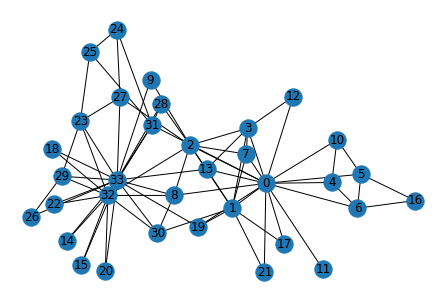

In [9]:
X = nx.karate_club_graph()
nx.draw(X, with_labels=True)
plt.show()

### Edge Betweenness Algo

[Girvan Newman by Anuradha Bhatia](https://www.youtube.com/watch?v=LtQoPEKKRYM)

In [10]:
def _single_source_shortest_path_basic(G, s):
    #initialize variables
    shortest_path = []
    predecessors = {}
    for v in G:
        predecessors[v] = []
     
    sigma = dict.fromkeys(G, 0.0)
    sigma[s] = 1.0

    D = {}
    D[s] = 0
    
    queue = [s]
    
    # use BFS to find shortest paths
    while queue: 
        v = queue.pop(0)
        shortest_path.append(v)
        Dv = D[v]
        sigmav = sigma[v]
        for w in G[v]:
            if w not in D:
                queue.append(w)
                D[w] = Dv + 1
                
            if D[w] == Dv + 1:   # this is a shortest path, count paths
                sigma[w] += sigmav
                predecessors[w].append(v)  # predecessors
                
    return shortest_path, predecessors, sigma

def _accumulate_edges(betweenness, shortest_path, predecessors, sigma, s):
    
    delta = dict.fromkeys(shortest_path, 0)
    while shortest_path:
        w = shortest_path.pop()
        coeff = (1 + delta[w]) / sigma[w]
        for v in predecessors[w]:
            c = sigma[v] * coeff
            if (v, w) not in betweenness:
                betweenness[(w, v)] += c
            else:
                betweenness[(v, w)] += c
            delta[v] += c
        if w != s:
            betweenness[w] += delta[w]
            
    return betweenness

def edge_betweenness_centrality(G):
    
    # b[v]=0 for v in G
    betweenness = dict.fromkeys(G, 0.0)  
    
    # b[e]=0 for e in G.edges()
    betweenness.update(dict.fromkeys(G.edges(), 0.0))
    
    for n in G:
        
        # use BFS
        shortest_path, predecessors, sigma = _single_source_shortest_path_basic(G, n)
        
        # accumulation
        betweenness = _accumulate_edges(betweenness, shortest_path, predecessors, sigma, n)
        
    # rescaling
    for n in G:  # remove nodes to only return edges
        del betweenness[n]

    for e in betweenness:
        betweenness[e] *= 0.5
    
    return betweenness

#### We can now calcualte the betweenness for our smaller graph X. Here we will receive a list of betweenness values for each edge in the graph

In [11]:
betweenness = edge_betweenness_centrality(X)
betweenness

{(0, 1): 14.166666666666664,
 (0, 2): 43.638888888888886,
 (0, 3): 11.5,
 (0, 4): 29.333333333333332,
 (0, 5): 43.83333333333333,
 (0, 6): 43.833333333333336,
 (0, 7): 12.80238095238095,
 (0, 8): 41.64841269841271,
 (0, 10): 29.333333333333332,
 (0, 11): 33.0,
 (0, 12): 26.099999999999994,
 (0, 13): 23.77063492063493,
 (0, 17): 22.509523809523813,
 (0, 19): 25.770634920634926,
 (0, 21): 22.50952380952381,
 (0, 31): 71.39285714285712,
 (1, 2): 13.033333333333335,
 (1, 3): 4.333333333333333,
 (1, 7): 4.164285714285714,
 (1, 13): 6.9595238095238106,
 (1, 17): 10.490476190476187,
 (1, 19): 8.209523809523809,
 (1, 21): 10.490476190476187,
 (1, 30): 18.10952380952381,
 (2, 3): 12.583333333333332,
 (2, 7): 14.145238095238092,
 (2, 8): 5.147619047619047,
 (2, 9): 17.28095238095238,
 (2, 13): 4.28095238095238,
 (2, 27): 23.10873015873016,
 (2, 28): 12.780952380952376,
 (2, 32): 38.70158730158729,
 (3, 7): 1.8880952380952383,
 (3, 12): 6.899999999999997,
 (3, 13): 8.37142857142857,
 (4, 6): 2.66

#### The edge with the maximum betweeness is given by the call below and this will be the edge that should first be removed when we run the Girvan Newman algorithm

In [12]:
max(betweenness, key=betweenness.get)

(0, 31)

### Girvan Newman Algo (Top-down approach)

##### This method keeps removing edges with maximum betweenness from Graph until splits into two communities

In [16]:
#parameters : G = the graph, k=number of iteration (by default it will compute until the end)
def girvan_newman(G, k = -1):
    
    startIteration = k
    graph = G.copy()
    
    # no of components
    initial_number_components = nx.number_connected_components(graph)    
    
    # stop when we have more communities compare to when we started
    current_number_components = initial_number_components
    
    # with a precised number of iteration :
    ignoreK = k < 0
    while current_number_components <= initial_number_components:
        if not ignoreK and k <= 0:
            break;
            
        # edge betweenness for G
        bw = edge_betweenness_centrality(graph)   

        # find the edge with max centrality (n1, n2)
        central_edge = max(bw, key=bw.get)

        #remove the central edge
        graph.remove_edge(central_edge[0],central_edge[1])  

        # recalculate the no of components
        current_number_components = nx.number_connected_components(graph)

        #remove an iteration
        k = k - 1

    if(k > 0):
        print("Number of iteration done before the reaching the end of Girvan Newman algorithm = {0}".format(startIteration - k))
    
    return graph

#### We can run the Girvan Newman algorithm on our small graph now and see the communities that are found

First iteration

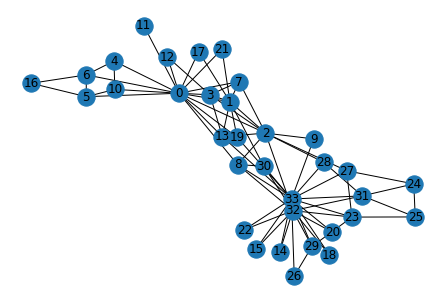

In [17]:
newGraph = girvan_newman(X, 1)
nx.draw(newGraph, with_labels=True)
plt.show()

Second iteration

In [18]:
betweenness = edge_betweenness_centrality(newGraph)
max(betweenness, key=betweenness.get)

(0, 2)

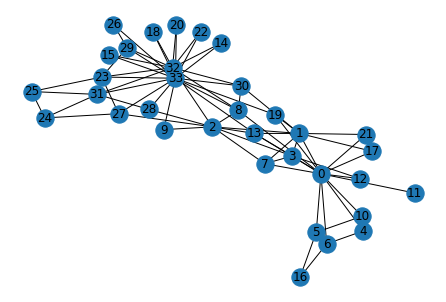

In [19]:
newGraph = girvan_newman(newGraph, 1)

nx.draw(newGraph, with_labels=True)
plt.show()

##### Now we run without a max number of iterations

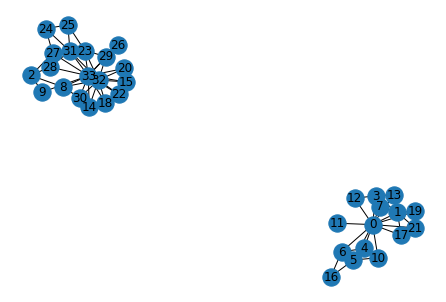

In [20]:
newGraph = girvan_newman(X)

nx.draw(newGraph, with_labels=True)
plt.show()

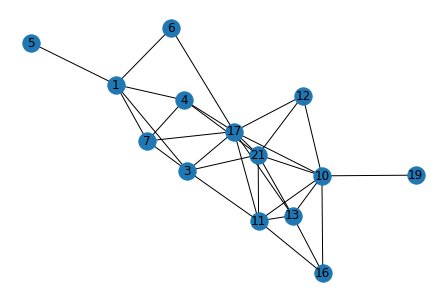

{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}


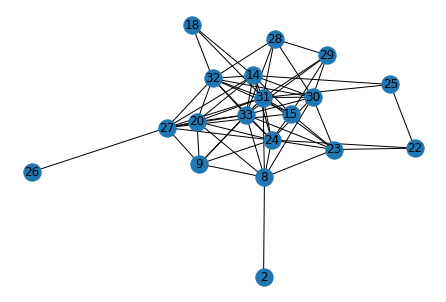

{2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


In [21]:
newGraphComps = nx.connected_components(newGraph)
for newGraphComp in newGraphComps:
    subGraph = fullG.subgraph(newGraphComp)
    nx.draw(subGraph, with_labels=True)
    plt.show()
    print(newGraphComp)

#### Use built in Girvan Newman

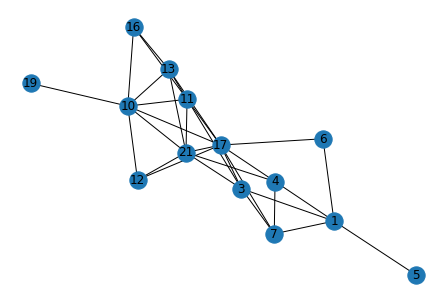

{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}


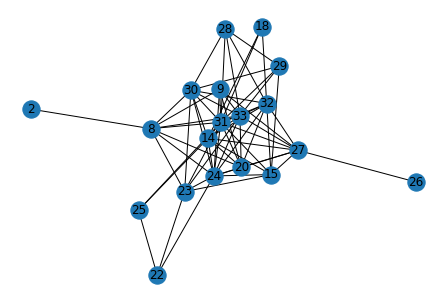

{2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


In [94]:
Y = nx.karate_club_graph()
comp = nx.algorithms.community.centrality.girvan_newman(Y)

k = 2
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    for community in communities:
        subGraph = fullG.subgraph(community)
        nx.draw(subGraph, with_labels=True)
        plt.show()
        print(community)

### Applied to the full graph

#### After having seen the effects on our small graph let's apply it to the entire network
Since there are 2.1M edges in the full graph we have to analyze, it will take a while to compute the betweenness for each edge. The program will spend a lot of time in the algorithm that calculates the shortest path.

In [17]:
#afterGirvanGraph = girvan_newman(fullG)

#nx.draw(afterGirvanGraph, with_labels=True)
#plt.show()

Therefore in order to at least test our algorithm on this graph, we will compute only the first iteration of Girvan Newman on it:

In [18]:
#afterGirvanGraph = girvan_newman(fullG,1)
#print("Number of compononents after first iteration = {0}".format(nx.number_connected_components(graph)))

### Implement the Degree centrality measure

The degree centrality of a node is simply its degree, which is the number of edges which are connected to it.

Let's take an example with the node 10 and calculte its degree :

In [ ]:
nodetendegree = fullG.degree[10]
print("Node 10 has degree "+str(nodetendegree))
print("It is linked to the following nodes :"+str([n for n in fullG[10]]))

However, the degree centrality of a node is usually normalized, so this is what we are going to do :

In [22]:
normalized_degree = nodetendegree / (len(fullG.nodes)-1)
print("Normalized degree of node 10 : "+str(normalized_degree))

#### Now we will implement a function which computes the normalized degree centrality for every node and return it in a dictionnary:

In [23]:
def degree_centrality_measure(G):
    nodes = G.nodes
    number_of_nodes = len(nodes)
    max_possible_degree = (number_of_nodes-1)
    results = dict()
    for node in nodes:
        normalized_degree = G.degree[node] / max_possible_degree
        results[node] = normalized_degree
    return results

Let's see if it works by finding the node with the highest degree centrality :

In [24]:
degreeC = degree_centrality_measure(fullG)
maxDegreeCentralityNode = max(degreeC, key=degreeC.get)
maxDegreeCentralityValue = max(degreeC.values())
print("The node which has the highest degree centrality is the node "
      +str(maxDegreeCentralityNode)+" with a value of : "+str(maxDegreeCentralityValue))

## 3) Analysis

### Identify users’ communities in the blog network using Girvan-Newman. Evaluate with different values of the iteration level.

Complexity = O(m^2n)

As the computing time is very high, we define another function for girvan-newman which will directly print the results for each iteration :

In [25]:
#parameters : G = the graph, k=number of iteration (by default it will compute until the end)
def girvan_newman_analysis(G, k=0):
    startIteration = k
    graph = G.copy()
    # no of components
    initial_number_components = nx.number_connected_components(graph)    
    
    # stop when we have more communities compare to when we started
    current_number_components = initial_number_components
    # with a precised number of iteration :
    if k != 0:
        while k > 0 and current_number_components <= initial_number_components:
            # edge betweenness for G
            bw = edge_betweenness_centrality(graph)   

            # find the edge with max centrality (n1, n2)
            central_edge = max(bw, key=bw.get)

            #remove the central edge
            graph.remove_edge(central_edge[0],central_edge[1])  

            # recalculate the no of components
            current_number_components = nx.number_connected_components(graph)
            
            #remove an iteration
            k = k-1
            
            #print results for this iteration
            print("Iteration {0}:".format(startIteration - k))
            print("------------------------------------------")
            print("Number of components = {0}".format(current_number_components))
    else:
        iterationNb = 0
        while current_number_components <= initial_number_components:
            # edge betweenness for G
            bw = edge_betweenness_centrality(graph)   

            # find the edge with max centrality (n1, n2)
            central_edge = max(bw, key=bw.get)

            #remove the central edge
            graph.remove_edge(central_edge[0],central_edge[1])  

            # recalculate the no of components
            current_number_components = nx.number_connected_components(graph)
            
            # register iteration
            iterationNb = iterationNb + 1
            #print results for this iteration
            print("------------------------------------------")
            print("Iteration {0}:".format(iterationNb))
            print("Number of components = {0}".format(current_number_components))
    if(k > 0):
        print("Number of iteration done before the reaching the end of Girvan Newman algorithm = {0}".format(startIteration - k))
    return graph

See if it works with our example graph :

In [27]:
afterGirvanNewmanGraph = girvan_newman_analysis(X)

------------------------------------------
Iteration 1:
Number of components = 2
------------------------------------------
Iteration 2:
Number of components = 3


### Identify the top k users with the highest Degree centrality in the graph. Experiment with different values of k and choose the most appropriate one.

Let's create a function which list the top k users with highest Degree centrality :

In [28]:
def k_nodes_max_degreeC(dictionary, k):
    k_nodes = heapq.nlargest(k, dictionary, key=dictionary.get)
    results = dict()
    for node in k_nodes:
        results[node] = dictionary[node]
    return results

Let's test it with different values of k

In [29]:
def print_k_top(degreeC, k_list):
    for k in k_list:
        i = 1
        print("Top "+str(k)+" :")
        print("-----------------")
        result_dict = k_nodes_max_degreeC(degreeC, k)
        for entry in result_dict:
            print("{0:3d}) Node: {1:5d}, Value: {2:.3f}".format(i, entry, result_dict[entry]))
            i = i+1
        print("----------------")

In [30]:
degreeC = degree_centrality_measure(fullG)
print_k_top(degreeC, [5,10,20,50,100])

The top 7 is quite appropriate with a degree centrality higher or equal to 0.100

In [31]:
print_k_top(degreeC, [7])

### Evaluate different random walk strategies to spread a message across the network. The message should reach as many different communities as possible.

#### Fully random walk

In [88]:
#random walk trial 1 with a number of step as a stopping condition

#parameters --> G : the graph, steps: the number of steps of the walk
def fully_random_walk(G, steps):
    #Define a starting node
    randomStartNode = random.randint(0, len(G.nodes)-1)
    #List of visited nodes of the walk: here a node can appear more than one time as the walk is fully random
    walk = [randomStartNode]
    #Define the walk : at each step, we register the newly visited node and we go to another one
    currentNode = randomStartNode
    while steps > 0:
        #find the neighbors of the current node
        neighbors = [n for n in G.neighbors(currentNode)]
        #choose the next node from the neighbors
        nextNode = random.choice(neighbors)
        #register the next node in the walk
        walk.append(nextNode)
        #change current node
        currentNode = nextNode
        #remove one step
        steps = steps - 1
    return walk

In [92]:
fully_random_walk(fullG, 10)

[22673, 12802, 6154, 1272, 7425, 15581, 532, 979, 19888, 96, 6651]

#### No walk allowed on a previously visited node

Now we create a condition such that the walk can't pass through a node that was already visited

In [93]:
#random walk trial 2 with a number of steps or having no neighbor available as stopping conditions

#parameters --> G : the graph, steps: the number of steps of the walk
def no_repetition_random_walk(G, steps):
    startingSteps = steps
    # Define a starting node
    randomStartNode = random.randint(0, len(G.nodes)-1)
    # List and set of visited nodes 
    # We use a set for a faster computation, but still keep a list as a set does not keep the order
    walk = [randomStartNode]
    walkSet = set()
    walkSet.add(randomStartNode)
    # Define the walk : at each step, we register the newly visited node and we go to another one
    currentNode = randomStartNode
    while steps > 0:
        # find the neighbors of the current node
        neighbors = [n for n in G.neighbors(currentNode)]
        # choose the next node from the neighbors
        nextNode = random.choice(neighbors)
        if nextNode not in walkSet:
            walk.append(nextNode)
            walkSet.add(nextNode)
            
        else:
            while (nextNode not in walkSet) != True:
                #remove the option of nextNode as it was already visited
                neighbors.remove(nextNode)
                #choose another neighbor
                if len(neighbors) > 0:
                    nextNode = random.choice(neighbors)
                else:
                    print("No unvisited neighbor at this point. Stop here.")
                    print("Number of steps : {0}".format(startingSteps - steps))
                    return walk
            walk.append(nextNode)
            walkSet.add(nextNode)
        #change current node
        currentNode = nextNode
        # remove one step
        steps = steps - 1
    return walk

In [99]:
# Check if a given list contains any duplicates
def checkIfDuplicates(listOfElems):
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True

In [110]:
walk = no_repetition_random_walk(fullG, 10000)
if checkIfDuplicates(walk) == False:
    print("There are no duplicates in this walk.")
else:
    print("There are duplicates in this walk.")

No unvisited neighbor at this point. Stop here.
Number of steps : 202
There are no duplicates in this walk.


#### No walk allowed on a previously visited node, with tracing back allowed

The previous function stopped very early. We will therefore add the ability to come back at the previously visited node if no neighbor is available at the current node.

In [167]:
#random walk trial 3 with a number of steps or having no neighbor available as stopping conditions, traceback allowed

#parameters --> G : the graph, steps: the number of steps of the walk
def traceback_random_walk(G, steps):
    startingSteps = steps
    # Define a starting node
    randomStartNode = random.randint(0, len(G.nodes)-1)
    # List and set of visited nodes 
    # We use a set for a faster computation, but still keep a list as a set does not keep the order
    walk = [randomStartNode]
    walkSet = set()
    walkSet.add(randomStartNode)
    # Define the walk : at each step, we register the newly visited node and we go to another one
    currentNode = randomStartNode
    while steps > 0:
        comeBackStep = -1
        # find the neighbors of the current node
        neighbors = [n for n in G.neighbors(currentNode)]
        # choose the next node from the neighbors
        nextNode = random.choice(neighbors)
        if nextNode not in walkSet:
            walk.append(nextNode)
            walkSet.add(nextNode)
        else:
            while (nextNode not in walkSet) != True:
                #remove the option of nextNode as it was already visited
                neighbors.remove(nextNode)
                #choose another neighbor
                if len(neighbors) > 0:
                    nextNode = random.choice(neighbors)
                #if there is no neighbor available, we come back and try to find another path
                else:
                    if comeBackStep < -len(walk):
                        print("No more path possible.")
                        return walk
                    previousNode = walk[comeBackStep]
                    #find next node from previous node neighbors
                    neighbors = [n for n in G.neighbors(previousNode)]
                    nextNode = random.choice(neighbors)
                    comeBackStep = comeBackStep - 1
            walk.append(nextNode)
            walkSet.add(nextNode)
        #change currentNode
        currentNode = nextNode
        # remove one step
        steps = steps - 1
    return walk

Let's try to visit 20000 different nodes with that function (a step equal to a new node visited) :

In [184]:
walk = traceback_random_walk(fullG, 20000)
if checkIfDuplicates(walk) == False:
    print("There are no duplicates in this walk.")
else:
    print("There are duplicates in this walk.")
print("Number of nodes visited + the starting node : {0}".format(len(walk)))

There are no duplicates in this walk.
Number of nodes visited + the starting node : 20001


#### Random walk to find communities

There is an algorithm called Walktrap to identify communities with a random walk and merging with modularity which performs very well regarding the computing time (way better than girvan newman !) => O(n^2 log n)

Reference for walktrap : Pons, P., & Latapy, M. (2005, October). Computing communities in large networks using random walks. In International symposium on computer and information sciences (pp. 284-293). Springer, Berlin, Heidelberg.

Source code in python : https://igraph.org/python/doc/igraph-pysrc.html#Graph.community_walktrap

# 4) Visualization

### Visualize the output of Girvan-Newman by coloring the nodes according to their assigned communities.

resource: https://stackoverflow.com/questions/50828284/networkx-specifying-colors-to-communities-nodes-in-a-graph

TypeError: object of type 'generator' has no len()

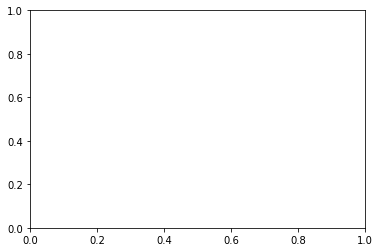

In [42]:
X = nx.karate_club_graph()
newGraph = girvan_newman(X)

color = ['b', 'r', 'g']
i = 0
pos = nx.spring_layout(newGraph)

newGraphComps = nx.connected_components(newGraph)
newGraphCompsList = nx.connected_components(newGraph)

for newGraphComp in newGraphComps:
    subGraph = fullG.subgraph(newGraphComp)
    nx.draw_networkx_nodes(subGraph, pos, nodelist=newGraphComp[i], node_color=color[i])
    i = i + 1
    plt.show()
    print(newGraphComp)

### Visualize the top k users with highest Degree centrality and their 1 degree neighbors.

In [37]:
def one_degree_neighbor(neighbors, G):
    results = []
    for node in neighbors:
        if G.degree[node] == 1:
            results.append(node)
    return results

In [38]:
def visualize_k_top(degreeC, k, G):
    #configurate plot
    fig=plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111) # the big subplot
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    
    rows = k
    #choose what to plot
    result_dict = k_nodes_max_degreeC(degreeC, k)
    i = 1
    print("Top "+str(k)+" :")
    print("-----------------")
    for node in result_dict:
        list_nodes = one_degree_neighbor([n for n in G[node]], G)
        list_nodes.append(node)
        subG = G.subgraph(list_nodes)
        subplot = fig.add_subplot(rows, 1, i)
        subplot.set_title(i)
        img = nx.draw_networkx(subG)
        i += 1
    plt.show

Top 7 :
-----------------


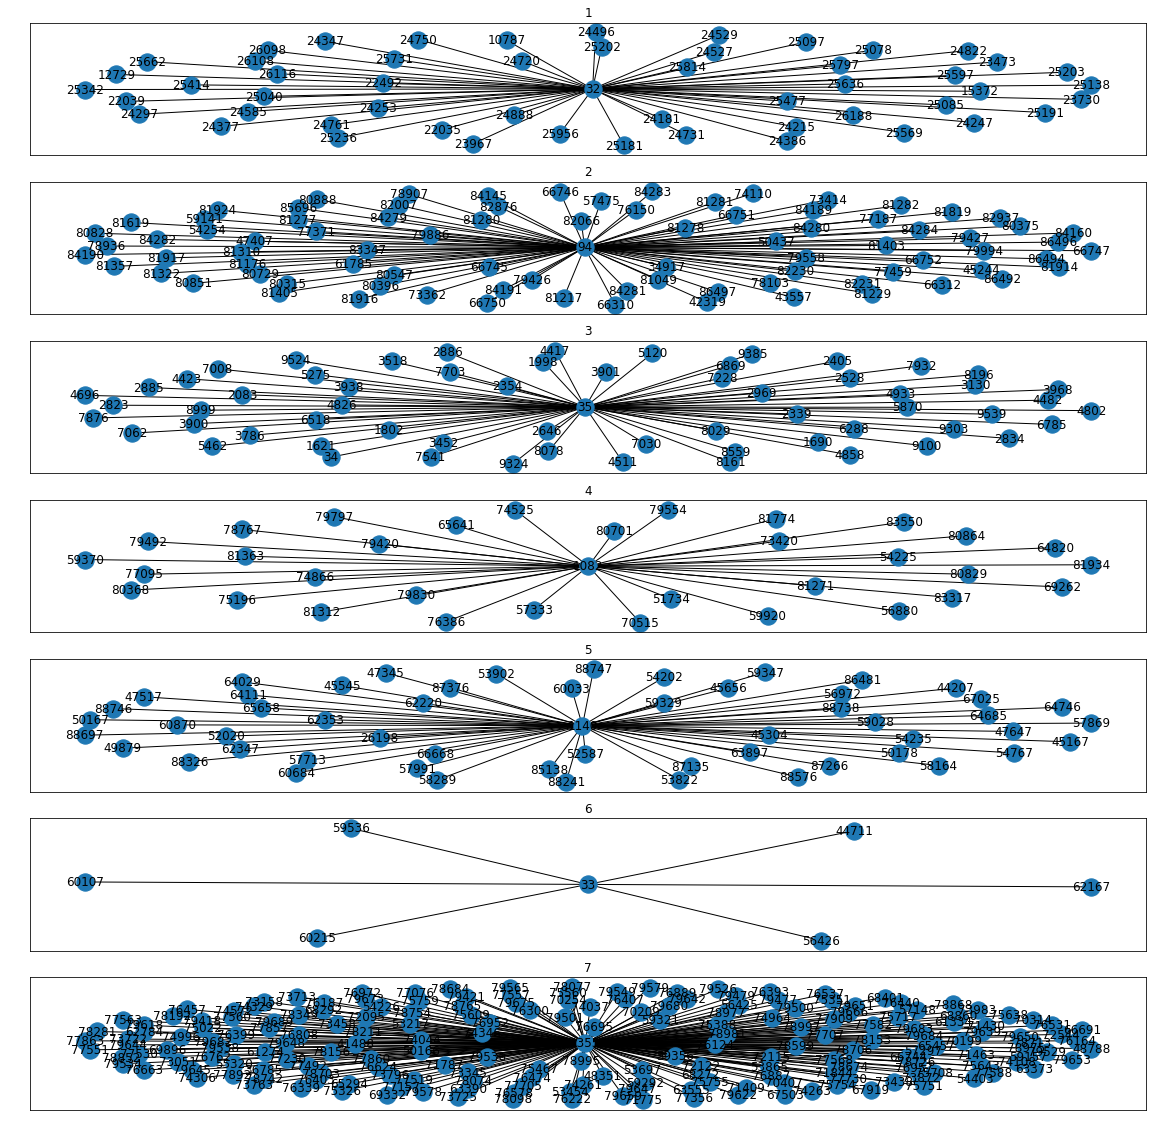

In [39]:
visualize_k_top(degree_centrality_measure(fullG), 7, fullG)